# Generate Amazon Reviews Dataset

In this notebook, we:
1. Download the WILDS Amazon Reviews benchmark dataset.
2. Use a subset of 10,000 to fine-tune a BERT model with the empirical risk minimization objective.
3. Apply the network to another held-out training sample of 10,000 examples, as well as validation and test sets of size 10,000 each.
4. Use the penultimate layer of the network outputs to generate frozen feature representations of the train, validation, and test sets described above.

The step requires the use of a GPU to run efficiently, listed as the `DEVICE` parameter below. 
Before running this notebook, please read the environment setup instructions in `README.md`. Then, you may download the `wilds` and `transformer` packages using the code below, and restarting the notebook.

In [1]:
%%capture

!pip install wilds
!pip install transformers

In [2]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

import numpy as np
import torch
from tqdm import tqdm
import datetime
import time
import random
import pickle
import os

from transformers import AutoTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset

## Fine-Tune BERT Model

We first create the fine-tuning set to use on the pre-trained BERT architecture. This involves downloading, splitting, and tokenizing the text.

In [3]:
LEARNING_RATE = 2e-5
ADAMW_TOLERANCE = 1e-8
BATCH_SIZE = 32
EPOCHS = 2
SEED = 123
FILENAME = "bert_amazon_finetuned"
DEVICE = 0

In [4]:
if torch.cuda.is_available():
    device = f"cuda:{DEVICE}"
else:
    device = "cpu"
print("Running on '%s'." % device)

Running on 'cuda:0'.


The dataset download takes (on the order of) 10 minutes.

In [5]:
# Load the full dataset, and download it if necessary.
dataset = get_dataset(dataset="amazon", download=True)

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


100%|█████████▉| 1988272128/1989805589 [06:40<00:00, 4969773.58Byte/s]


Extracting data/amazon_v2.1/archive.tar.gz to data/amazon_v2.1

It took 7.26 minutes to download and uncompress the dataset.



In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [7]:
def get_split(split, n, tokenizer):
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attn_masks = []
    labels = []
    metadata = []

    # For every sentence...
    # sentences = dataset[split]["text"]
    # train_data = dataset.get_subset(split)
    loader = get_train_loader("standard", dataset.get_subset(split), batch_size=1)
    # if split != "train":
    #     idx = np.arange(len(sentences))
    for i, (x, y, z) in tqdm(enumerate(loader)):
        encoded_dict = tokenizer.encode_plus(
            x[0],  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=80,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask = True,   # Construct attn. masks.
            return_tensors="pt",  # Return pytorch tensors.
        )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict["input_ids"])
        attn_masks.append(encoded_dict["attention_mask"])
        labels.append(y.item())
        metadata.append(z)

        if i == n - 1:
            break

    input_ids = torch.cat(input_ids, dim=0)
    attn_masks = torch.cat(attn_masks, dim=0)
    labels = torch.tensor(labels).long()
    metadata = torch.cat(metadata)

    return input_ids, attn_masks, labels, metadata

class Amazon(Dataset):
    def __init__(self, input_ids, attn_masks, labels, metadata):
        self.input_ids = input_ids
        self.attn_masks = attn_masks
        self.labels = labels
        self.metadata = metadata

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, i):
        return self.input_ids[i], self.attn_masks[i], self.labels[i], self.metadata[i]

Create dataloaders for the non-convex training set (`train`) and convex training set (`finetune`) set.

In [8]:
# Create dataloaders.
np.random.seed(123)
n = 20000
finetune_idx = np.random.choice(n, 10000, replace=False)
train_idx = np.delete(np.arange(n), finetune_idx)
print(np.intersect1d(finetune_idx, train_idx))
print(len(np.unique(np.union1d(finetune_idx, train_idx))))

input_ids, attn_masks, labels, metadata = get_split("train", n, tokenizer)

train_dataset = Amazon(input_ids[train_idx], attn_masks[train_idx], labels[train_idx], metadata[train_idx])
train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} training samples.".format(len(train_dataset)))

[]
20000


0it [00:00, ?it/s]/home/ronak/miniconda3/envs/dro/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
19999it [00:31, 635.37it/s]


10,000 training samples.


## Generate Validation and Test Set

Next, we apply the same method to tokenize and create dataloaders for the validation and test set.

In [9]:
val_dataset = Amazon(*get_split("val", 10000, tokenizer))
validation_dataloader = DataLoader(
    val_dataset, sampler=SequentialSampler(val_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} validation samples.".format(len(val_dataset)))

test_dataset = Amazon(*get_split("test", 10000, tokenizer))
test_dataloader = DataLoader(
    test_dataset, sampler=RandomSampler(test_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} test samples.".format(len(test_dataset)))

9999it [00:14, 690.77it/s]


10,000 validation samples.


9999it [00:13, 715.57it/s]


10,000 test samples.


## Train Model 

We run the standard training loop for `N_EPOCHS` epochs.

In [10]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=5,
    output_attentions=False,
    output_hidden_states=True,
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# utility functions
def format_time(elapsed):
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [12]:
optimizer = AdamW(model.parameters(), lr = LEARNING_RATE, eps = ADAMW_TOLERANCE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = EPOCHS * BATCH_SIZE * len(train_dataloader))

/home/ronak/miniconda3/envs/dro/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


The full training loop is run below.

In [13]:
# Seed everything.
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

training_stats = []
total_t0 = time.time()
for epoch_i in range(EPOCHS):

    # ========================================
    #               Training
    # ========================================

    print("")
    print("======== Epoch {:} / {:} ========".format(epoch_i + 1, EPOCHS))
    print("Training...")

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.".format(
                    step, len(train_dataloader), elapsed
                )
            )

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        output = model(
            b_input_ids,
            attention_mask=b_input_mask,
            labels=b_labels,
            return_dict=True,
        )

        loss = output.loss
        logits = output.logits
        

        total_train_loss += loss.item()

        loss.backward()

        # TODO: See if this is needed.
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss = output.loss
            logits = output.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            "epoch": epoch_i + 1,
            "Training Loss": avg_train_loss,
            "Valid. Loss": avg_val_loss,
            "Valid. Accur.": avg_val_accuracy,
            "Training Time": training_time,
            "Validation Time": validation_time,
        }
    )

print("")
print("Training complete!")

print(
    "Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0))
)

# Save the model.
torch.save(model, f"{FILENAME}.pt")
pickle.dump(
    training_stats, open(f"training_stats_{FILENAME}.p", "wb")
)


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:09.
  Batch    80  of    313.    Elapsed: 0:00:18.
  Batch   120  of    313.    Elapsed: 0:00:26.
  Batch   160  of    313.    Elapsed: 0:00:35.
  Batch   200  of    313.    Elapsed: 0:00:44.
  Batch   240  of    313.    Elapsed: 0:00:53.
  Batch   280  of    313.    Elapsed: 0:01:02.

  Average training loss: 0.92
  Training epcoh took: 0:01:09

Running Validation...
  Accuracy: 0.62
  Validation Loss: 0.83
  Validation took: 0:00:27

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    313.    Elapsed: 0:00:09.
  Batch    80  of    313.    Elapsed: 0:00:18.
  Batch   120  of    313.    Elapsed: 0:00:27.
  Batch   160  of    313.    Elapsed: 0:00:36.
  Batch   200  of    313.    Elapsed: 0:00:45.
  Batch   240  of    313.    Elapsed: 0:00:55.
  Batch   280  of    313.    Elapsed: 0:01:04.

  Average training loss: 0.73
  Training epcoh took: 0:01:11

Running Validation...
  Accuracy: 0.64
 

## Visualize Embeddings

Next, we visualize the learned last-layer embeddings to observe separations between classes, indicating that they have picked up the required signal.

In [14]:
%%capture

model = torch.load(f"{FILENAME}.pt")
model.eval()

In [15]:
def get_hidden_states(dataloader):
    model.eval()
    hidden_states = []
    labels = []
    metadata = []
    for batch in tqdm(dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_metadata = batch[3]
        with torch.no_grad():
            output = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            hidden_states.append(torch.mean(output.hidden_states[-1], dim=1))
            labels.append(b_labels)
            metadata.append(b_metadata)
    return torch.cat(hidden_states, dim=0).cpu().numpy(), torch.cat(labels, dim=0).cpu().numpy(), torch.cat(metadata, dim=0).cpu().numpy()

In [16]:
split_dataset = Amazon(input_ids[finetune_idx], attn_masks[finetune_idx], labels[finetune_idx], metadata[finetune_idx])
split_dataloader = DataLoader(
    split_dataset, sampler=RandomSampler(split_dataset), batch_size=BATCH_SIZE
)
print("{:>5,} fine-tuning samples.".format(len(split_dataset)))

10,000 fine-tuning samples.


In [17]:
x_train, y_train, z_train = get_hidden_states(split_dataloader)
x_val, y_val, z_val = get_hidden_states(validation_dataloader)
x_test, y_test, z_test = get_hidden_states(test_dataloader)

x_train = x_train / np.linalg.norm(x_train, axis=1)[:, None]
x_val = x_val / np.linalg.norm(x_val, axis=1)[:, None]
x_test = x_test / np.linalg.norm(x_test, axis=1)[:, None]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

100%|██████████| 313/313 [00:27<00:00, 11.55it/s]


(10000, 768)
(10000, 768)
(10000, 768)


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

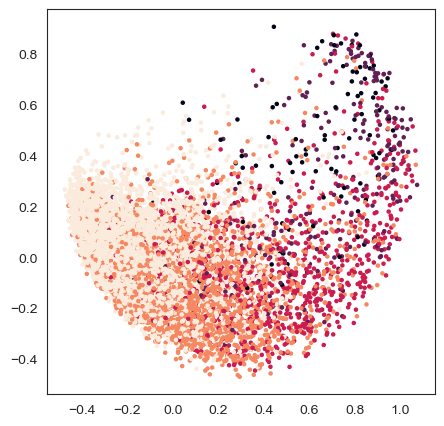

In [19]:
sns.set_style("white")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x = PCA(n_components=2).fit_transform(x_train)

ax.scatter(x[:, 0], x[:, 1], c=y_train, s=5)

We reduce the dimension of the embeddings using principle components analysis (PCA).

In [20]:
embed_dim = x_train.shape[1]
pca = PCA(n_components=embed_dim).fit(x_train)

threshold = 0.9
cumsum = 0.0
for i, eig in enumerate(pca.explained_variance_ratio_):
    cumsum += eig
    if cumsum >= threshold:
        n_components = i + 1
        print(f"{cumsum} variance explained by {n_components}/{embed_dim} components.")
        break

X_train = pca.transform(x_train)[:, 0:n_components]
X_val   = pca.transform(x_val)[:, 0:n_components]
X_test  = pca.transform(x_test)[:, 0:n_components]

0.9005915388697758 variance explained by 122/768 components.


Finally, we save the resulting output.

In [21]:
dataset = "amazon"
os.makedirs(f"../data/{dataset}", exist_ok=True)

np.save(f"../data/{dataset}/X_train.npy", X_train)
np.save(f"../data/{dataset}/y_train.npy", y_train)
np.save(f"../data/{dataset}/z_train.npy", z_train)
np.save(f"../data/{dataset}/X_val.npy", X_val)
np.save(f"../data/{dataset}/y_val.npy", y_val)
np.save(f"../data/{dataset}/z_val.npy", z_val)
np.save(f"../data/{dataset}/X_test.npy", X_test)
np.save(f"../data/{dataset}/y_test.npy", y_test)
np.save(f"../data/{dataset}/z_test.npy", z_test)